# Otimizadores do gradiente descendente

Este exercício foi inspirado no tutorial apresentado em: https://morvanzhou.github.io/tutorials/

Este post tem uma excelente descrição dos principais métodos de otimização:
http://ruder.io/optimizing-gradient-descent/


## Gradiente descendente

$$ W_{t+1} = W_t - \eta \nabla J(W_t) $$

## Gradiente descendente - Momentum


$$ v_{t+1} = \gamma v_t + \nabla J(W_t) $$
$$ W_{t+1} = W_t - \eta v_{t+1}$$

## Gradiente descendente - Momentum - Nesterov

$$ v_{t+1} = \gamma v_{t} + \nabla J(W_t - \gamma v_{t}) $$
$$ W_{t+1} = W_{t} - \eta v_{t+1}$$

## Gradiente descendente - Métodos com learning rates diferentes para cada dimensão do gradiente


$$ W_{t+1,i} = W_{t,i} - \frac{\eta}{\sqrt{G_{t,ii} + \epsilon}} \nabla J(W_t)$$

- Adagrad: Termo $G_{t,ii}$ é soma do quadrado dos gradientes na época
- RMSprop e Adadelta: Termo $G_{t,ii}$ é média móvel do termo $G$ passada (possui termo momentum)
- Adam: adiciona a média móvel tanto no termo $G$ mas também no gradiente $\nabla J(W)$

In [1]:
import torch
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1);    #semente do gerador pseudoaleatório

In [3]:
LR = 0.01
BATCH_SIZE = 50
EPOCH = 6
REGR_RN = False  # opção: True: Regressão Linear, False: Rede neural 2 camadas

## Geração sintética do dataset

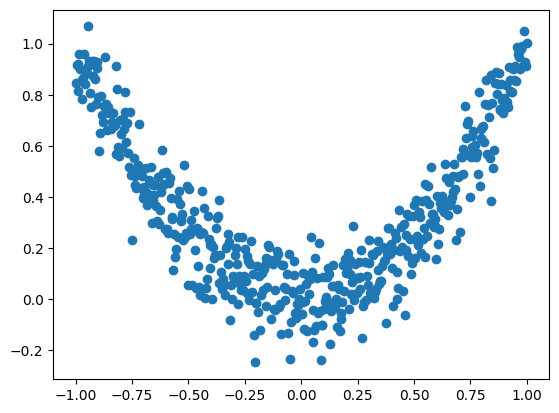

In [4]:
x = torch.unsqueeze(torch.linspace(-1, 1, 500), dim=1)
if REGR_RN:
    y = 0.25 * x + 0.68 + 0.1*torch.normal(torch.zeros(*x.size()))
else:
    y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

plt.scatter(x.numpy(), y.numpy())
plt.show()

## Criando dataset e loader

In [5]:
torch_dataset = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

## Rede neural 2 camadas

In [6]:
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.predict = torch.nn.Linear(1, 1)   # saída
        torch.nn.init.constant_(self.predict.weight,0) # peso em 0
        torch.nn.init.constant_(self.predict.bias,0.)  # bias em 0

    def forward(self, x):
        x = self.predict(x)
        return x

In [7]:
class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)    # camada escondida
        self.predict = torch.nn.Linear(20, 1)   # saída
        torch.nn.init.constant_(self.predict.weight,0) # peso em 0
        torch.nn.init.constant_(self.predict.bias,0.)  # bias em 0

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

## Uma rede com otimizador diferente

In [8]:
net_SGD         = Net1() if REGR_RN else Net2()
net_Momentum    = Net1() if REGR_RN else Net2()
net_Nesterov    = Net1() if REGR_RN else Net2()
net_RMSprop     = Net1() if REGR_RN else Net2()
net_Adam        = Net1() if REGR_RN else Net2()
nets = [net_SGD, net_Momentum, net_Nesterov, net_RMSprop, net_Adam]

## Cinco otimizadores, um para cada rede

In [9]:
opt_SGD      = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_Nesterov = torch.optim.SGD(net_Nesterov.parameters(), lr=LR, momentum=0.9, nesterov=True)
opt_RMSprop  = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam     = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers   = [opt_SGD, opt_Momentum, opt_Nesterov, opt_RMSprop, opt_Adam]

In [10]:
loss_func = torch.nn.MSELoss()
losses_his = [[], [], [], [], []]   # record loss
ws_his = [[],[],[],[],[]] # record w
bs_his = [[],[],[],[],[]] # record b

## training

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5


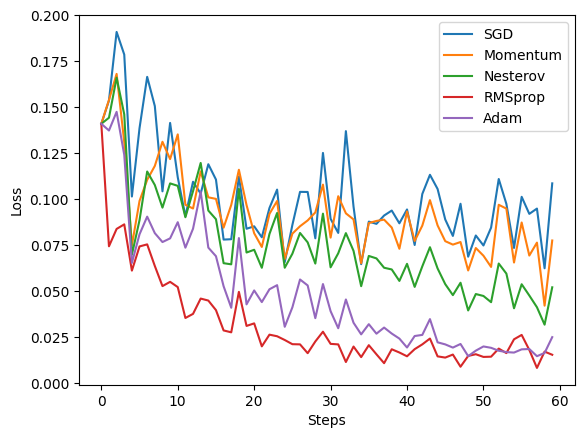

In [11]:
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (batch_x, batch_y) in enumerate(loader):          # for each training step
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        for net, opt, l_his, w_his, b_his in zip(nets, optimizers, losses_his, ws_his, bs_his):
            output = net(b_x)              # get output for every net
            loss = loss_func(output, b_y)  # compute loss for every net
            opt.zero_grad()                # clear gradients for next train
            loss.backward()                # backpropagation, compute gradients
            opt.step()                     # apply gradients
            l_his.append(loss.data)     # loss recoder
            w = net.predict.weight.data.numpy()[0,0]
            w_his.append(w)
            b = net.predict.bias.data.numpy()[0]
            b_his.append(b)

labels = ['SGD', 'Momentum', 'Nesterov', 'RMSprop', 'Adam']
if REGR_RN:
    for i, (w_his, b_his) in enumerate(zip(ws_his,bs_his)):
        plt.scatter(b_his,w_his,label=labels[i])
else:
    for i, l_his in enumerate(losses_his):
        plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()